In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import time

print(tf.__version__)
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.initializers import RandomNormal

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Conv1DTranspose,AveragePooling1D,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D,MaxPool2D,Conv2DTranspose,AveragePooling2D,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Conv3DTranspose,AveragePooling3D,GlobalMaxPool3D,GlobalAveragePooling3D
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,Layer,BatchNormalization,Input,Add,Activation,Average



2.10.1


In [2]:
#data_path = "outlineOutput"
data_path = "H:\\download\\blender\\projects\\vdmTests\\outlineOutput"
output_path = "H:\\tmp\\dexined"

train_path = data_path + "/train/*"
edge_train_path = data_path + "/train_edge/*"

test_path = data_path + "/test/*"
edge_test_path = data_path + "/test_edge/*"

val_path = data_path + "/val/*"
edge_val_path = data_path + "/val_edge/*"

print(edge_test_path)


H:\download\blender\projects\vdmTests\outlineOutput/test_edge/*


In [3]:
def load_data(ipath, epath):
    images = sorted(glob(os.path.join(ipath)))
    edges = sorted(glob(os.path.join(epath)))
    return images, edges

In [4]:
images, edges = load_data(train_path, edge_train_path)
valimg, valedg = load_data(val_path, edge_val_path)
#print(len(images), len(edges))

In [5]:
#print(len(testimg), len(testedg))

In [6]:
def read_image(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_edge(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W,H))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    x = x.astype(np.float32)
    return x

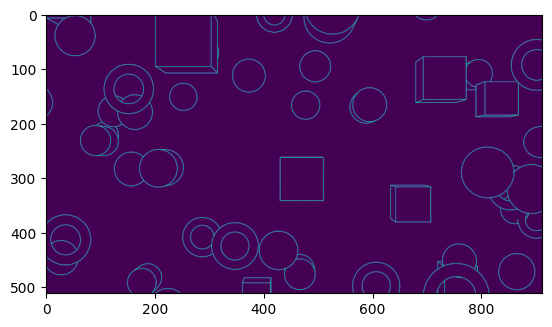

In [7]:

img = read_edge(data_path+"/train_edge/dense_000.png", H=512, W=912)
plt.imshow(img)

In [8]:
def preprocess(x,y,H=512, W=912):

    def f(x,y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_edge(y)
        return x, y

    images, edges = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([H, W, 3])
    edges.set_shape([H, W, 1])
    return images, edges

In [9]:
def tf_data(x,y):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(buffer_size=100)
    data = data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(4)
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data


In [10]:
train_data = tf_data(images, edges)
val_data = tf_data(valimg, valedg)

In [11]:
#for x, y in train_data:
#  print(x.shape, y.shape)
#
print(len(train_data),len(val_data))


4953 552


In [12]:
def pre_process_binary_cross_entropy(bc_loss,input, label, use_tf_loss=False):
    # preprocess data
    y = label
    loss = 0
    w_loss=1.0
    preds = []
    #for tmp_p in input:
    # tmp_p = input[i]
    tmp_p = input
    # loss processing
    tmp_y = tf.cast(y, dtype=tf.float32)
    mask = tf.dtypes.cast(tmp_y > 0., tf.float32)
    b,h,w,c=mask.get_shape()
    positives = tf.math.reduce_sum(mask, axis=[1, 2, 3], keepdims=True)
    negatives = h*w*c-positives

    beta2 = (1.*positives) / (negatives + positives) # negatives in hed
    beta = (1.1*negatives)/ (positives + negatives) # positives in hed
    pos_w = tf.where(tf.equal(y, 0.0), beta2, beta)
    logits = tf.sigmoid(tmp_p)

    l_cost = bc_loss(y_true=tmp_y, y_pred=logits,
                     sample_weight=pos_w)

    preds.append(logits)
    loss += (l_cost*w_loss)

    return preds, loss

In [13]:

def train(model,model_name,train_data,test_data,lr,beta1,max_epochs,batch_size):
    # Validation and Train dataset generation

    train_data = train_data
    n_train =len(train_data) #data_cache["n_files"]
    val_data = test_data
    
    # Summary and checkpoint manager
    model_dir = model_name
    summary_dir = os.path.join(output_path,'logs',model_dir)
    train_log_dir=os.path.join(summary_dir,'train')
    val_log_dir =os.path.join(summary_dir,'test')

    checkpoint_dir = os.path.join(output_path,"checkpoint_dir",model_dir)
    epoch_ckpt_dir = checkpoint_dir + 'epochs'
    os.makedirs(epoch_ckpt_dir, exist_ok=True)
    os.makedirs(train_log_dir,exist_ok=True)
    os.makedirs(val_log_dir,exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    train_writer = tf.summary.create_file_writer(train_log_dir)
    val_writer = tf.summary.create_file_writer(val_log_dir)

    my_model = model

    # accuracy = metrics.SparseCategoricalAccuracy()
    accuracy = metrics.BinaryAccuracy()
    accuracy_val = metrics.BinaryAccuracy()
    loss_bc = losses.BinaryCrossentropy()
    optimizer = optimizers.Adam(
        learning_rate=lr, beta_1=beta1)
    iter = 0

    imgs_res_folder = os.path.join(output_path,model_dir, "current_training")
    os.makedirs(imgs_res_folder, exist_ok=True)
    global_loss = 1000.
    t_loss = []
    ckpt_save_mode = "h5"
    tmp_lr = lr
    for epoch in range(max_epochs):
        # training
        t_loss = []
        # if epoch in self.args.adjust_lr:
        tmp_lr=tmp_lr*0.1
        optimizer.lr.assign(tmp_lr)
        for step, (x, y) in enumerate(train_data):

            with tf.GradientTape() as tape:
                pred = my_model(x, training=True)

                preds, loss = pre_process_binary_cross_entropy(
                    loss_bc, pred, y, use_tf_loss=False)

            accuracy.update_state(y_true=y, y_pred=preds[-1])
            gradients = tape.gradient(loss, my_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))

            # logging the current accuracy value so far.
            t_loss.append(loss.numpy())
            if step % 10 == 0:
                print("Epoch:", epoch, "Step:", step, "Loss: %.4f" % loss.numpy(),
                        "Accuracy: %.4f" % accuracy.result(), time.ctime())

            #if step % 10 == 0:
            #    # visualize preds
            #    img_test = 'Epoch: {0} Sample {1}/{2} Loss: {3}' \
            #        .format(epoch, step, n_train // batch_size, loss.numpy())
            #    vis_imgs = visualize_result(
            #        x=x[2], y=y[2], p=preds, img_title=img_test)
            #    cv.imwrite(os.path.join(imgs_res_folder, 'results.png'), vis_imgs)
            if step % 20 == 0 and loss < global_loss:  # 500
                if epoch==0 and step==0:
                    tmp_loss = np.array(t_loss)
                    with train_writer.as_default():
                        tf.summary.scalar('loss', tmp_loss.mean(), step=epoch)
                        tf.summary.scalar('accuracy', accuracy.result(), step=epoch)

                save_ckpt_path = os.path.join(checkpoint_dir, "DexiNedL_model.h5")
                Model.save_weights(my_model, save_ckpt_path, save_format='h5')

                global_loss = loss
                print("Model saved in:  ", save_ckpt_path, "Current loss:", global_loss.numpy())

            iter += 1  # global iteration

        t_loss = np.array(t_loss)
        # train summary
        if epoch!=0:
            with train_writer.as_default():
                tf.summary.scalar('loss', t_loss.mean(), step=epoch)
                tf.summary.scalar('accuracy', accuracy.result(), step=epoch)

        Model.save_weights(my_model, os.path.join(epoch_ckpt_dir, "DexiNed{}_model.h5".format(str(epoch))),
                            save_format=ckpt_save_mode)
        print("Epoch:", epoch, "Model saved in Loss: ", t_loss.mean())

        # validation
        t_val_loss = []
        for i, (x_val, y_val) in enumerate(val_data):

            pred_val = my_model(x_val)
            v_logits, V_loss = pre_process_binary_cross_entropy(
                loss_bc, pred_val, y_val, use_tf_loss=False)
            accuracy_val.update_state(y_true=y_val, y_pred=v_logits[-1])
            t_val_loss.append(V_loss.numpy())
            if i == 7:
                break
        val_acc = accuracy_val.result()
        t_val_loss = np.array(t_val_loss)
        print("Epoch(validation):", epoch, "Val loss: ", t_val_loss.mean(),
                "Accuracy: ", val_acc.numpy())
        # validation summary
        with val_writer.as_default():
            tf.summary.scalar('loss', t_val_loss.mean(), step=epoch)
            tf.summary.scalar('accuracy', val_acc.numpy(), step=epoch)

        # Reset metrics every epoch
        accuracy.reset_states()
        accuracy_val.reset_states()

    my_model.summary()


In [14]:
weight_init = tf.initializers.glorot_uniform()

l2 = regularizers.l2
w_decay=1e-3

glorot_normal = RandomNormal(stddev=0.01)

In [15]:
self_conv2D_1 = Conv2D(16 , kernel_size=(3,3),strides=(2,2),padding = 'same')
self_activation_1 = Activation(activation='sigmoid')
self_activation_15 = Activation(activation='log_softmax')
self_activation_8 = Activation(activation='tanh')
self_conv2D_2 = Conv2D(16 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_activation_25 = Activation(activation='sigmoid')
self_activation_9 = Activation(activation='log_softmax')
self_activation_11 = Activation(activation='tanh')
self_conv2D_3 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_5 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)
self_conv2D_10 = Conv2D(32 , kernel_size=(1,1),strides=(2,2),padding = 'same')
self_activation_2 = Activation(activation='sigmoid')
self_activation_22 = Activation(activation='sigmoid')
self_activation_13 = Activation(activation='log_softmax')
self_activation_16 = Activation(activation='log_softmax')
self_activation_14 = Activation(activation='tanh')
self_activation_7 = Activation(activation='tanh')
self_conv2D_4 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_transpoze2D_1 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)
self_conv2D_14 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)
self_maxpool2D_1 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_activation_12 = Activation(activation='sigmoid')

self_conv2D_11 = Conv2D(48 , kernel_size=(1,1),strides=(1,1),padding = 'same')
self_activation_5 = Activation(activation='log_softmax')
self_conv2D_12 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_activation_6 = Activation(activation='tanh')
self_activation_18 = Activation(activation='sigmoid')
self_transpoze2D_4 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)
self_activation_27 = Activation(activation='log_softmax')
self_activation_3 = Activation(activation='tanh')
self_conv2D_13 = Conv2D(48 , kernel_size=(3,3),strides=(1,1),padding = 'same')

self_conv2D_6 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)
self_activation_17 = Activation(activation='sigmoid')
self_activation_19 = Activation(activation='log_softmax')
self_activation_10 = Activation(activation='tanh')
self_transpoze2D_2 = Conv2DTranspose(16 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)
self_conv2D_7 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)
self_activation_20 = Activation(activation='sigmoid')
self_activation_21 = Activation(activation='log_softmax')
self_activation_4 = Activation(activation='tanh')
self_transpoze2D_3 = Conv2DTranspose(1 , kernel_size=(4,4),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal,kernel_regularizer= l2)

self_conv2D_8 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_9 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_activation_23 = Activation(activation='sigmoid')
self_activation_24 = Activation(activation='log_softmax')
self_activation_26 = Activation(activation='tanh')

self_concatenate_1 = Concatenate(axis=3)



x = Input(shape=(512,912,3))
conv2D_1 = self_conv2D_1(x)
activation_1 = self_activation_1(conv2D_1)
activation_15 = self_activation_15(activation_1)
activation_8 = self_activation_8(activation_15)
conv2D_2 = self_conv2D_2(activation_8)
activation_25 = self_activation_25(conv2D_2)
activation_9 = self_activation_9(activation_25)
activation_11 = self_activation_11(activation_9)
conv2D_3 = self_conv2D_3(activation_11)
conv2D_5 = self_conv2D_5(activation_11)
conv2D_10 = self_conv2D_10(activation_11)
activation_2 = self_activation_2(conv2D_3)
activation_22 = self_activation_22(conv2D_5)
activation_13 = self_activation_13(activation_2)
activation_16 = self_activation_16(activation_22)
activation_14 = self_activation_14(activation_13)
activation_7 = self_activation_7(activation_16)
conv2D_4 = self_conv2D_4(activation_14)
transpoze2D_1 = self_transpoze2D_1(activation_7)
conv2D_14 = self_conv2D_14(conv2D_4)
maxpool2D_1 = self_maxpool2D_1(conv2D_4)
activation_12 = self_activation_12(conv2D_14)
add_1 = Add()([conv2D_10,maxpool2D_1])
conv2D_11 = self_conv2D_11(maxpool2D_1)
activation_5 = self_activation_5(activation_12)
conv2D_12 = self_conv2D_12(add_1)
activation_6 = self_activation_6(activation_5)
activation_18 = self_activation_18(conv2D_12)
transpoze2D_4 = self_transpoze2D_4(activation_6)
activation_27 = self_activation_27(activation_18)
activation_3 = self_activation_3(activation_27)
conv2D_13 = self_conv2D_13(activation_3)
average_1 = Average()([conv2D_11,conv2D_13])
conv2D_6 = self_conv2D_6(average_1)
activation_17 = self_activation_17(conv2D_6)
activation_19 = self_activation_19(activation_17)
activation_10 = self_activation_10(activation_19)
transpoze2D_2 = self_transpoze2D_2(activation_10)
conv2D_7 = self_conv2D_7(transpoze2D_2)
activation_20 = self_activation_20(conv2D_7)
activation_21 = self_activation_21(activation_20)
activation_4 = self_activation_4(activation_21)
transpoze2D_3 = self_transpoze2D_3(activation_4)


tmp = [transpoze2D_1,transpoze2D_3,transpoze2D_4]
concatenate_1 = self_concatenate_1(tmp)
conv2D_8 = self_conv2D_8(concatenate_1)
conv2D_9 = self_conv2D_9(conv2D_8)
activation_23 = self_activation_23(conv2D_9)
activation_24 = self_activation_24(activation_23)
activation_26 = self_activation_26(activation_24)

model = keras.Model(inputs =x , outputs=activation_26)


H:\download\anaconda3_envs\generativeTensorflowCudaV2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 912, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 456, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 456, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 activation_20 (Activation)     (None, 128, 228, 16  0           ['activation_19[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 256, 456, 16  1040       ['activation_20[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 456, 1)  17          ['activation_5[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 256, 456, 1)  17          ['conv2d_transpose_2[0][0]']     
          

In [17]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam") #,
    #metrics=[tf.keras.metrics.BinaryAccuracy(),
     #        tf.keras.metrics.FalseNegatives(),
      #       tf.keras.metrics.FalsePositives(),
       #      tf.keras.metrics.TruePositives(),
        #    tf.keras.metrics.TrueNegatives()])

In [19]:
train(model,"teed_try1",train_data,val_data,0.0001,0.5,11,4)

Epoch: 0 Step: 0 Loss: 0.1602 Accuracy: 0.6372 Thu Nov  7 00:03:50 2024
Model saved in:   H:\tmp\dexined\checkpoint_dir\teed_try1\DexiNedL_model.h5 Current loss: 0.16024312
Epoch: 0 Step: 10 Loss: 0.1608 Accuracy: 0.6360 Thu Nov  7 00:03:57 2024
Epoch: 0 Step: 20 Loss: 0.1622 Accuracy: 0.6360 Thu Nov  7 00:04:05 2024
Epoch: 0 Step: 30 Loss: 0.1599 Accuracy: 0.6363 Thu Nov  7 00:04:12 2024
Epoch: 0 Step: 40 Loss: 0.1612 Accuracy: 0.6363 Thu Nov  7 00:04:21 2024
Epoch: 0 Step: 50 Loss: 0.1616 Accuracy: 0.6363 Thu Nov  7 00:04:28 2024


KeyboardInterrupt: 

In [ ]:
img_pre = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test\\dense_981.png')
img = np.expand_dims(img_pre, axis=0)
plt.imshow(img_pre)

In [ ]:
img_e = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test_edge\\dense_981.png')
#img = np.expand_dims(img, axis=0)
plt.imshow(img_e)

In [ ]:
#model.load_weights("H:\\tmp\\dexined\\checkpoint_dir\\dexined_tryepochs\\DexiNed10_model.h5")
res_pre = model.predict(img)
res = res_pre[-1,:,:]
plt.imshow(res)

In [ ]:
def image_normalization(img, img_min=0, img_max=255):
    """This is a typical image normalization function
    where the minimum and maximum of the image is needed
    source: https://en.wikipedia.org/wiki/Normalization_(image_processing)
    :param img: an image could be gray scale or color
    :param img_min:  for default is 0
    :param img_max: for default is 255
    :return: a normalized image, if max is 255 the dtype is uint8
    """
    img = np.float32(img)
    epsilon=1e-12 # whenever an inconsistent image
    img = (img-np.min(img))*(img_max-img_min)/((np.max(img)-np.min(img))+epsilon)+img_min
    return img

In [ ]:
import cv2
res2=res
res2[res2 < 0.0] = 0.0
out=cv2.bitwise_not(np.uint8(image_normalization(res2)))
plt.imshow(out, cmap='gray')